In [1]:
%matplotlib inline

# Load CIFAR10 dataset

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

trainset, valset = torch.utils.data.random_split(trainvalset, [0.9, 0.1])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


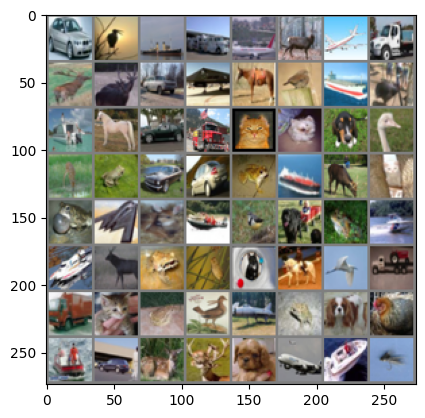

  car  bird  ship truck


In [5]:
# function to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# VGG16 Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG16_BN_Weights
import copy

vgg = models.vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)

# Prevent weight update from backprop
for param in vgg.parameters():
    param.requires_grad = False

# Change the output layer to 10 classes
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)


torch.Size([10, 4096])
torch.Size([10])


## Train the model

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return correct / total

vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [8]:
loss_epoch_arr = []
max_epochs = 30

n_iters = np.ceil(50000/batch_size)

min_loss = 1000

for epoch in range(max_epochs):
    
        for i, data in enumerate(trainloader, 0):
    
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    
            opt.zero_grad()
    
            outputs = vgg(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            
            if min_loss > loss.item():
                min_loss = loss.item()
                best_model = copy.deepcopy(vgg.state_dict())
                print('Min loss %0.2f' % min_loss)
            
            if i % 100 == 0:
                print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
                
            del inputs, labels, outputs
            torch.cuda.empty_cache()
    
        loss_epoch_arr.append(loss.item())
        
    
        print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
            epoch, max_epochs,
            evaluation(testloader, vgg), evaluation(trainloader, vgg)))

Iteration: 0/3125, Loss: 2.53
Iteration: 100/3125, Loss: 6.19
Iteration: 200/3125, Loss: 8.32
Iteration: 300/3125, Loss: 6.72
Iteration: 400/3125, Loss: 4.52
Iteration: 500/3125, Loss: 8.30
Iteration: 600/3125, Loss: 5.60
Iteration: 700/3125, Loss: 14.65
Iteration: 800/3125, Loss: 7.85
Iteration: 900/3125, Loss: 7.84
Iteration: 1000/3125, Loss: 4.41
Iteration: 1100/3125, Loss: 7.78
Iteration: 1200/3125, Loss: 5.73
Iteration: 1300/3125, Loss: 8.91
Iteration: 1400/3125, Loss: 6.32
Iteration: 1500/3125, Loss: 10.03
Iteration: 1600/3125, Loss: 8.61
Iteration: 1700/3125, Loss: 6.13
Iteration: 1800/3125, Loss: 8.06
Iteration: 1900/3125, Loss: 6.76
Iteration: 2000/3125, Loss: 6.96
Iteration: 2100/3125, Loss: 10.44
Iteration: 2200/3125, Loss: 7.98
Iteration: 2300/3125, Loss: 13.31
Iteration: 2400/3125, Loss: 8.23
Iteration: 2500/3125, Loss: 5.55
Iteration: 2600/3125, Loss: 7.13
Iteration: 2700/3125, Loss: 14.76
Iteration: 2800/3125, Loss: 7.97
Epoch: 0/30, Test acc: 0.33, Train acc: 0.33
Itera

KeyboardInterrupt: 

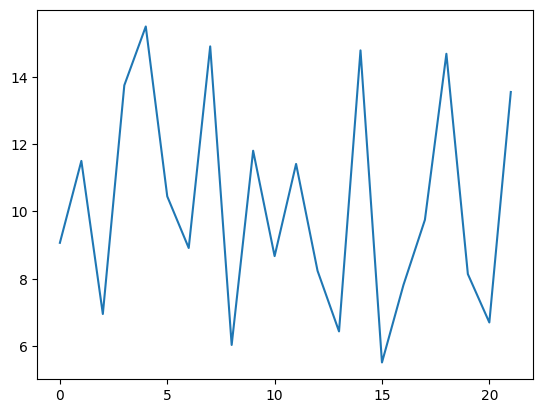

In [9]:
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))